In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

>> #### Import Libraries

In [25]:
import dvc.api
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Plotting imports
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import Image

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

# CausalML imports
from causalnex.structure.notears import from_pandas
from causalnex.structure import StructureModel
from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.evaluation import classification_report,roc_auc
from causalnex.discretiser.discretiser_strategy import DecisionTreeSupervisedDiscretiserMethod
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
sm = StructureModel()


>> #### Import Required modules

In [5]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from load_data import LoadData
from plot import Plot
from overview import Overview
from preprocessing import PreProcess
from causal import Causal

Initialize load data

In [6]:
loader = LoadData()
plot = Plot()
causal = Causal()

Load data from csv file using DVC

In [7]:
# Get URL from DVC
data_path = '../data/data.csv'
repo = 'https://github.com/jedisam/Causal_inference'
version = 'bee80042c3c966ec98d90c247a8ccac0e5fd8aca'

In [ ]:
# Load train data from dvc using the dvc.api.Dataset class
data_url = dvc.api.get_url(
    path=data_path,
    repo=repo,
    rev=version
)

In [7]:
data = loader.read_csv("../data/data_clean.csv")

In [8]:
overview = Overview(data)
prep = PreProcess(data)

In [9]:
data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.22862,0.28241,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.62695,0.7119,0.2654,0.41915,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.18660,0.2416,0.1860,0.27500,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.42450,0.4504,0.2430,0.36130,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.22862,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.62695,0.6869,0.2575,0.41915,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.20500,0.4000,0.1625,0.23640,0.07678,1


In [10]:
# Count missing values
overview.percent_missing(data)

The dataset contains 0.0 % missing values.


Display Feature importance

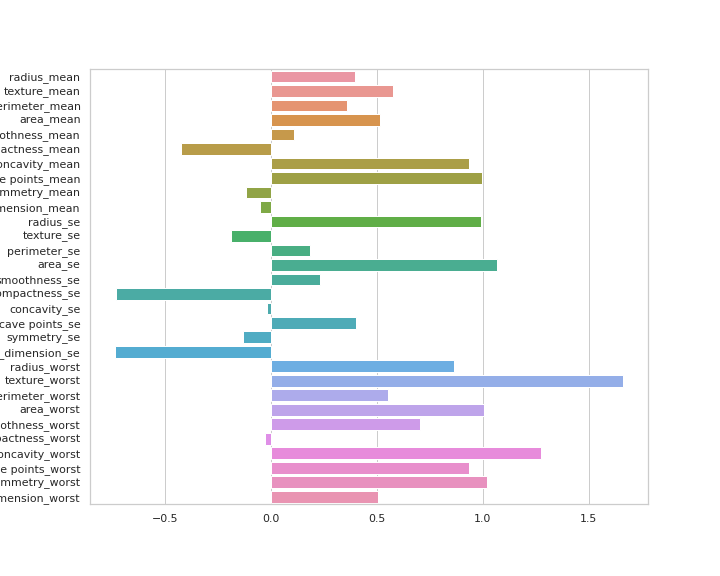

In [29]:
Image(filename='feature_importance.png') 

Based on the feature importance, we can see that the most important features are the ones that are most correlated with the target variable.
These are:

    > 'concave points_mean',
    > 'texture_mean',
    > 'concavity_mean',
    > 'concave points_mean',
    > 'radius_se',
    > 'radius_worst',
    > 'concave points_worst',
    > 'perimeter_worst',
    > 'area_mean',
    > 'area_worst',
    > 'perimeter_mean',
    > 'radius_mean'

In [30]:
sel_feat = data[['concave points_mean', 'texture_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'radius_worst', 'concave points_worst', 'perimeter_worst', 'area_mean', 'area_worst', 'perimeter_mean', 'radius_mean', 'diagnosis']]

In [11]:
sel_feat = data[['concavity_mean', 'radius_se', 'texture_worst', 'radius_worst', 'concave points_worst', 'perimeter_worst', 'area_mean', 'area_worst', 'perimeter_mean', 'radius_mean', 'diagnosis']]

In [11]:
sel_feat = data[['diagnosis', 'concave points_mean', 'radius_worst', 'concave points_worst', 'perimeter_worst', 'area_mean', 'area_worst', 'perimeter_mean', 'radius_mean']]

In [12]:
sel_feat.head()

,concavity_mean,radius_se,texture_worst,radius_worst,concave points_worst,perimeter_worst,area_mean,area_worst,perimeter_mean,radius_mean,diagnosis
0,0.28241,1.0950,17.33,25.38,0.2654,184.60,1001.0,2019.0,122.80,17.99,1
1,0.08690,0.5435,23.41,24.99,0.1860,158.80,1326.0,1956.0,132.90,20.57,1
2,0.19740,0.7456,25.53,23.57,0.2430,152.50,1203.0,1709.0,130.00,19.69,1
3,0.24140,0.4956,26.50,14.91,0.2575,98.87,386.1,567.7,77.58,11.42,1
4,0.19800,0.7572,16.67,22.54,0.1625,152.20,1297.0,1575.0,135.10,20.29,1


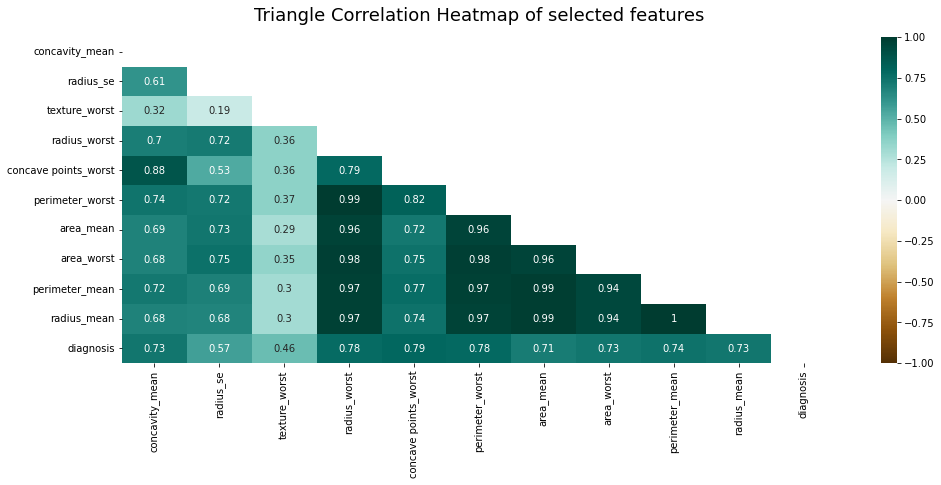

In [13]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(sel_feat.corr(), dtype=np.bool))
heatmap = sns.heatmap(sel_feat.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap of selected features', fontdict={'fontsize':18}, pad=16);
plt.show()

>> #### Creating causal graph 

Using 50% sample of data 

In [ ]:
sample_50 = sel_feat.sample(frac=0.5, random_state=42)
sm_50 = from_pandas(sample_50, tabu_parent_nodes=['diagnosis'])

threshold = 0

INFO:logger:Plotting Structure of Model


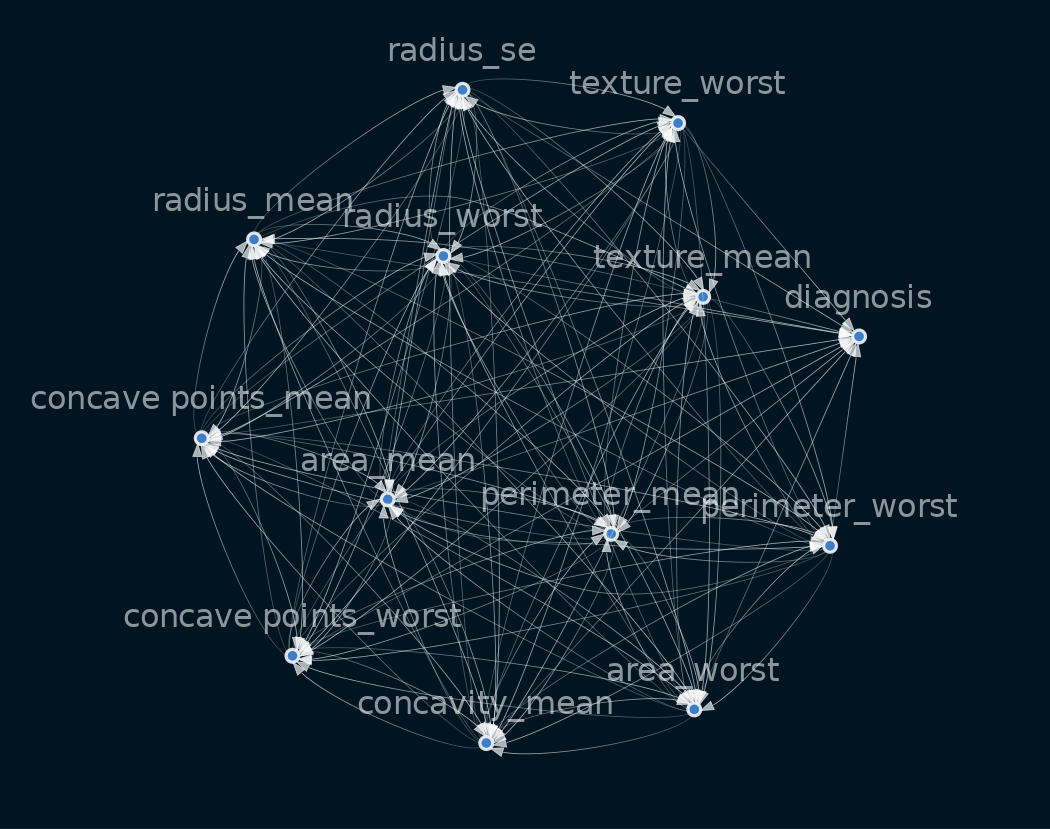

In [69]:
causal.plot_structure_model(sm_50, threshold=0)

With threshold = 0, all of the features are interconnected to each other.

threshold = 0.1

INFO:logger:Plotting Structure of Model


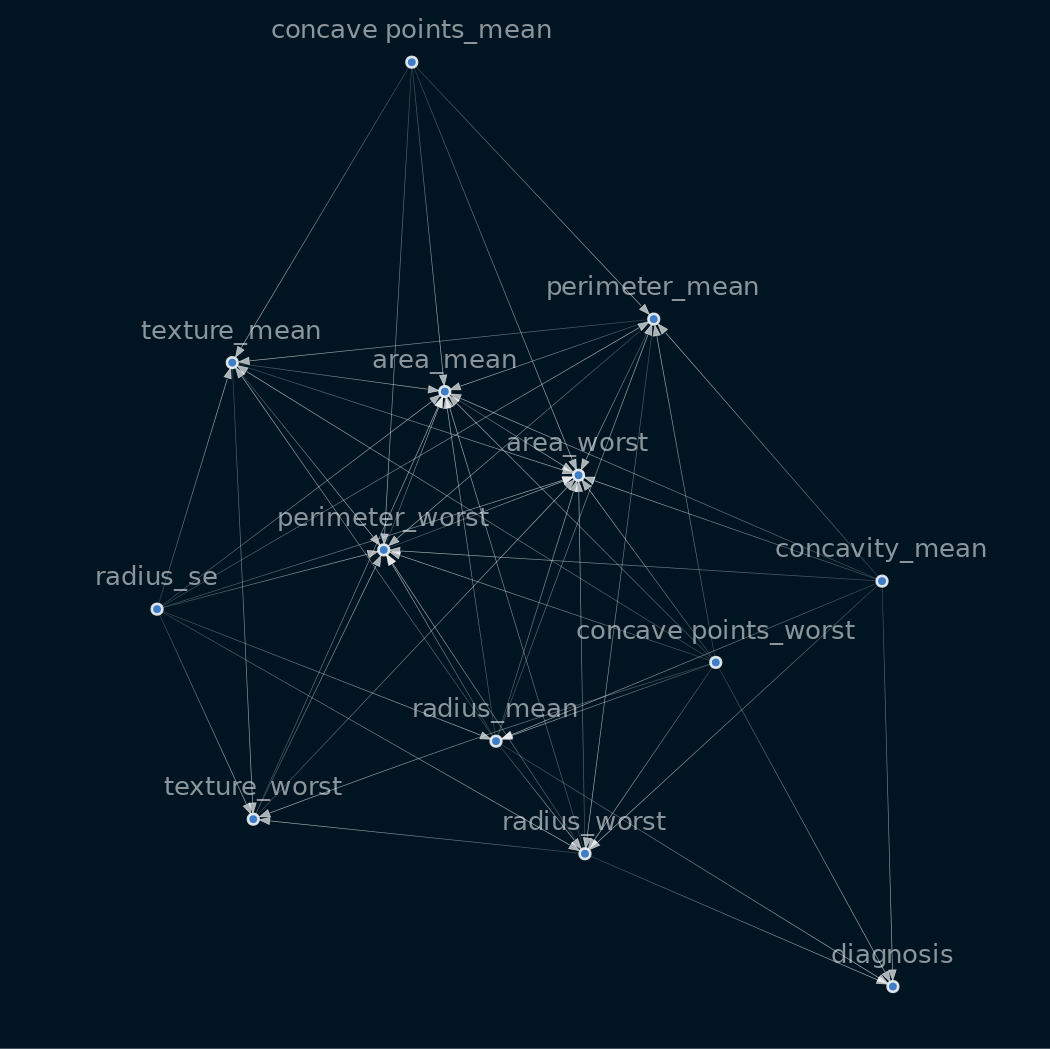

In [70]:
causal.plot_structure_model(sm_50, threshold=0.1)

With threshold = 0.1, diagnosis is connected to a lesser number of features.

threshold = 0.2

INFO:logger:Plotting Structure of Model


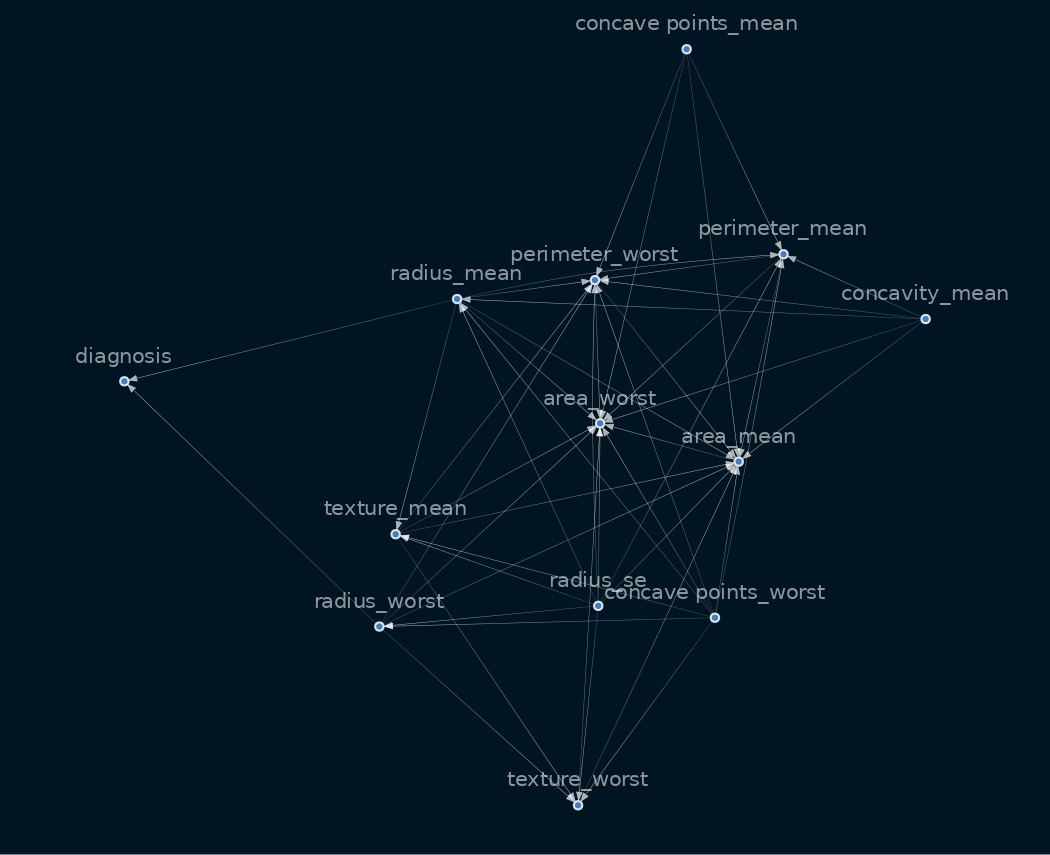

In [71]:
causal.plot_structure_model(sm_50, threshold=0.2)

threshold=0.3

INFO:logger:Plotting Structure of Model


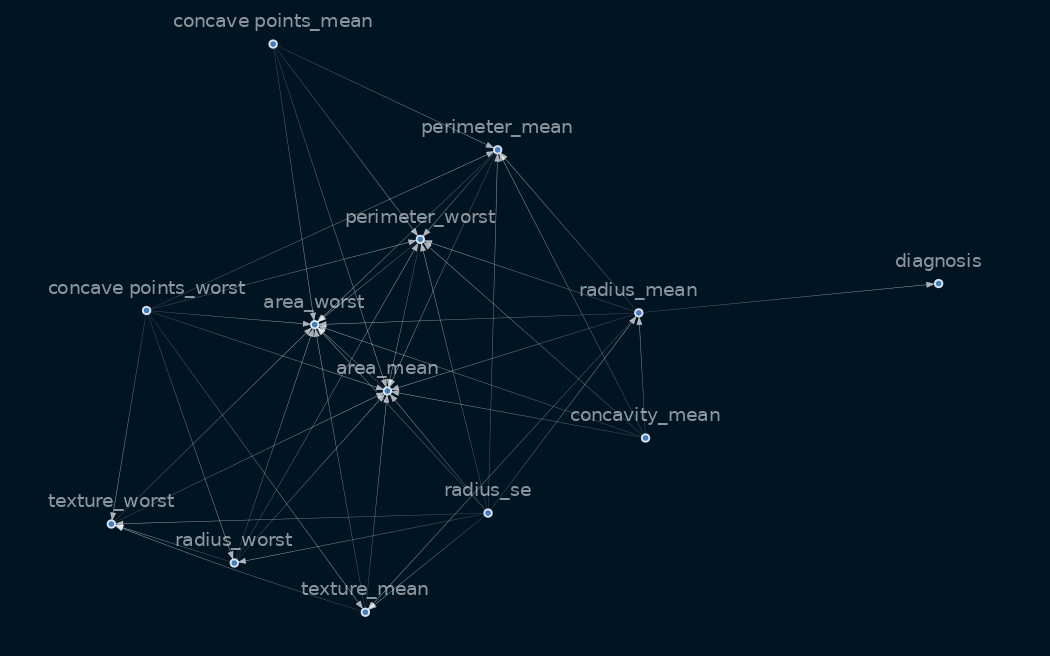

In [72]:
causal.plot_structure_model(sm_50, threshold=0.3)

threshold=0.4

INFO:logger:Plotting Structure of Model


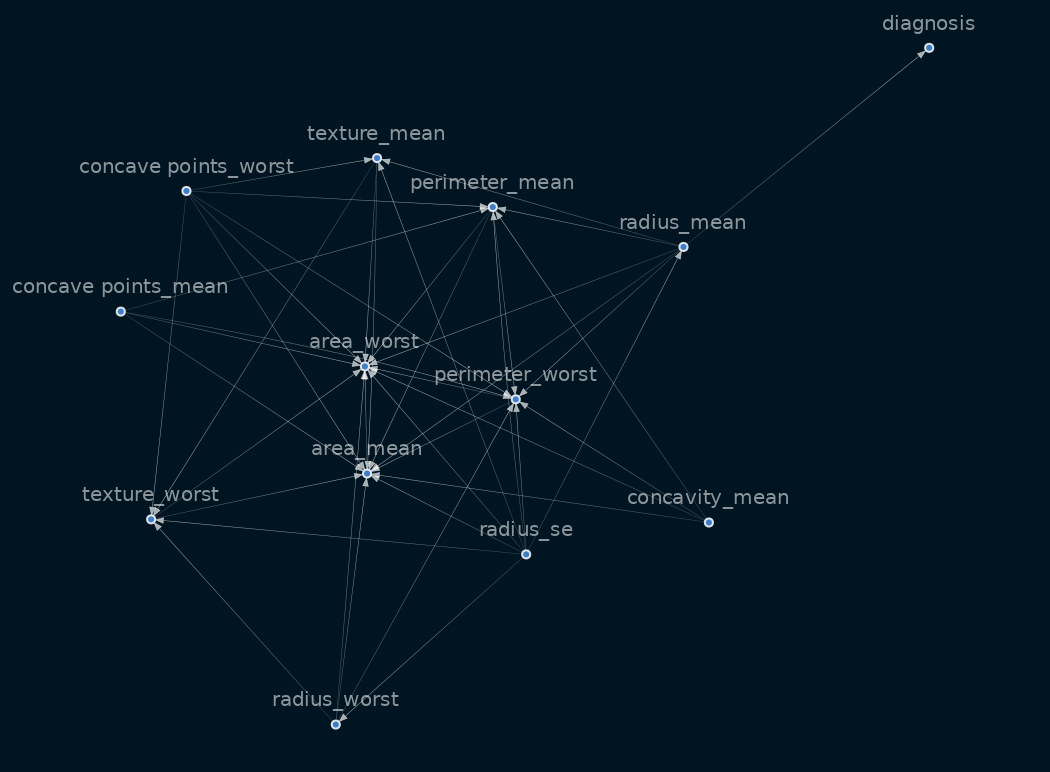

In [73]:
causal.plot_structure_model(sm_50, threshold=0.4)

threshold=0.5

INFO:logger:Plotting Structure of Model


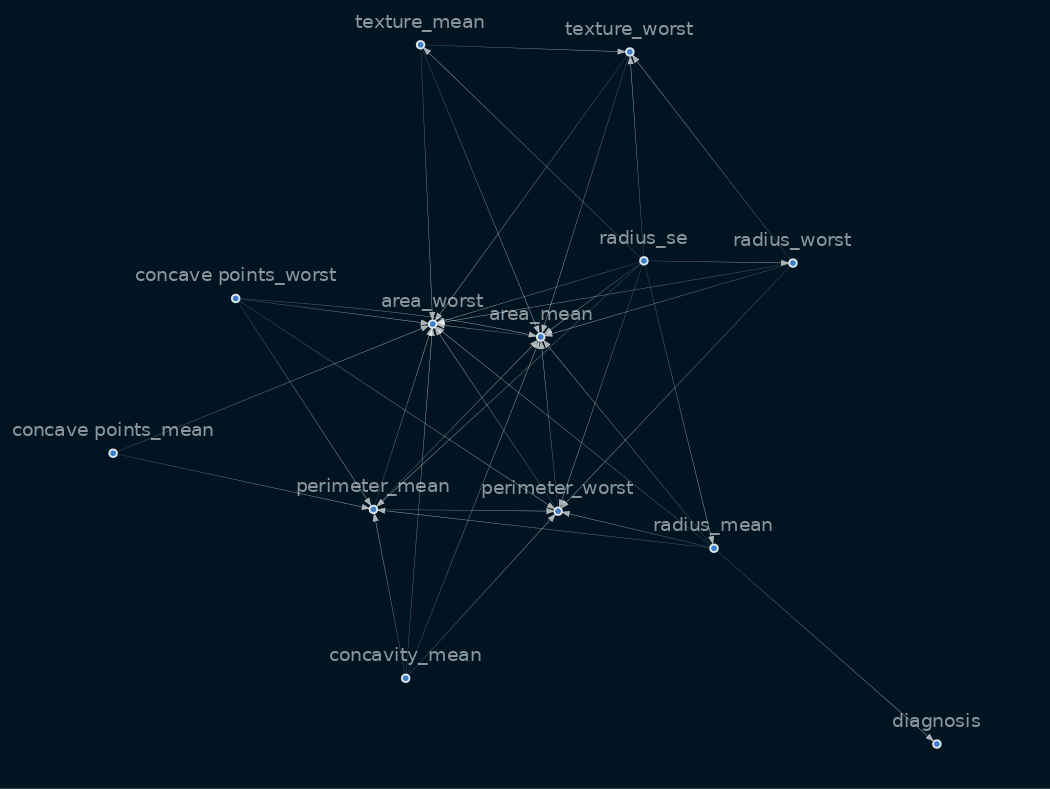

In [74]:
causal.plot_structure_model(sm_50, threshold=0.5)

threshold=0.6

INFO:logger:Plotting Structure of Model


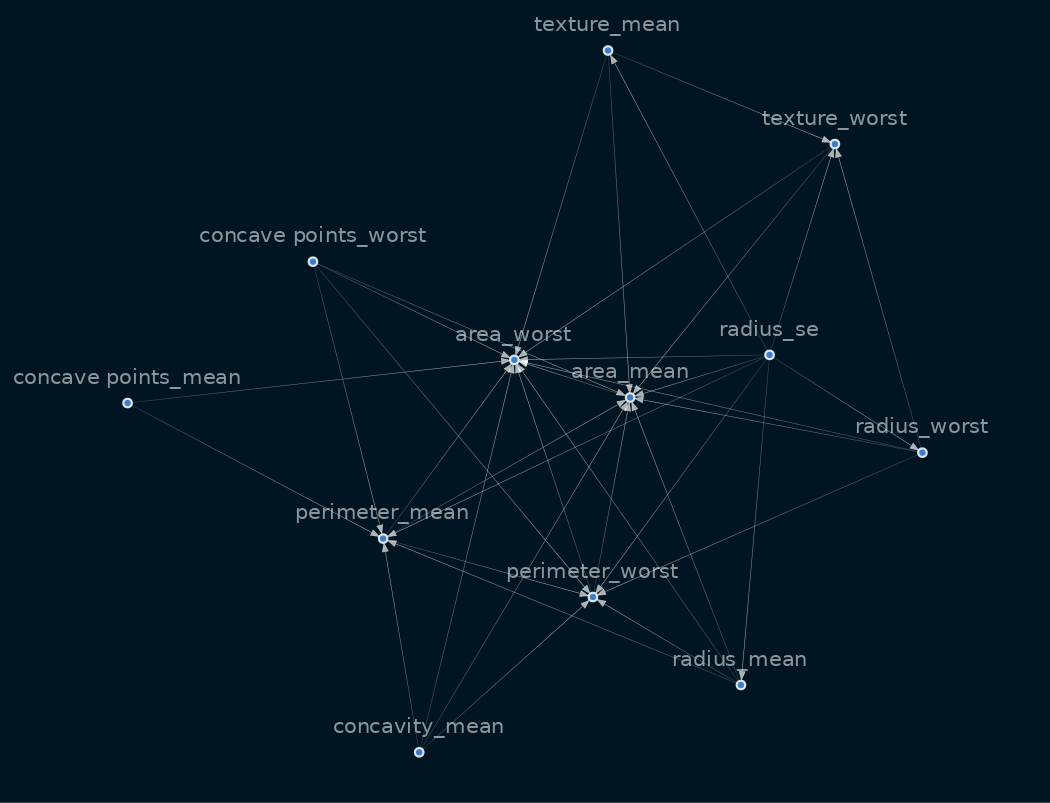

In [75]:
causal.plot_structure_model(sm_50, threshold=0.6)

On threshold=0.6, the target feature(diagnosis) has been removed. So, we will go for threshold=0.5.

>> ##### Using 80% sample of data

In [14]:
sample_80 = sel_feat.sample(frac=0.8, random_state=42)
sm_80 = from_pandas(sample_80, tabu_parent_nodes=['diagnosis'])

For the optimial threshold=0.5

INFO:logger:Plotting Structure of Model


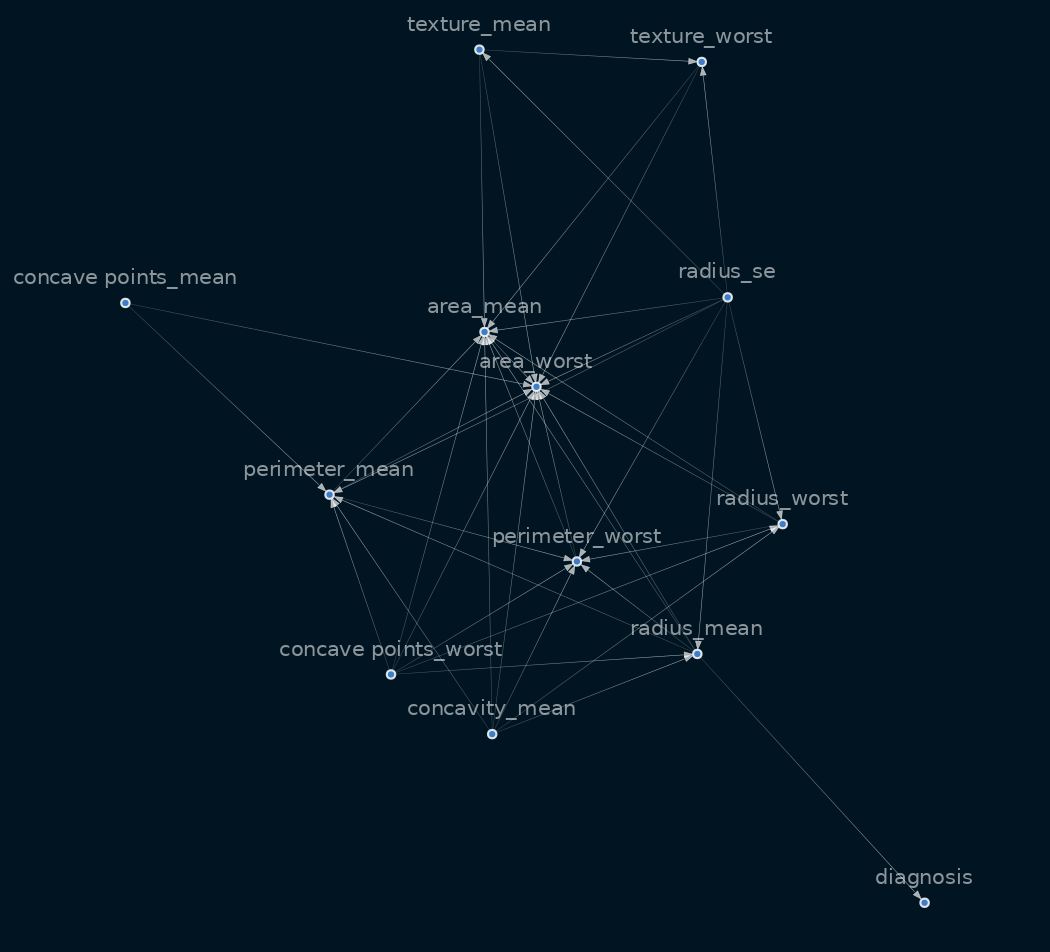

In [66]:
causal.plot_structure_model(sm_80, threshold=0.5)

>> ##### Jaccard similarity index

In [76]:
causal.jaccard_similarity(sm_50.nodes, sm.nodes)

INFO:logger:Calculating Jaccard Similarity
INFO:logger:calculated Jaccard Similarity


Modeling

In [13]:
sample_50 = sel_feat.sample(frac=0.8, random_state=42)
sm_50 = from_pandas(sample_50)

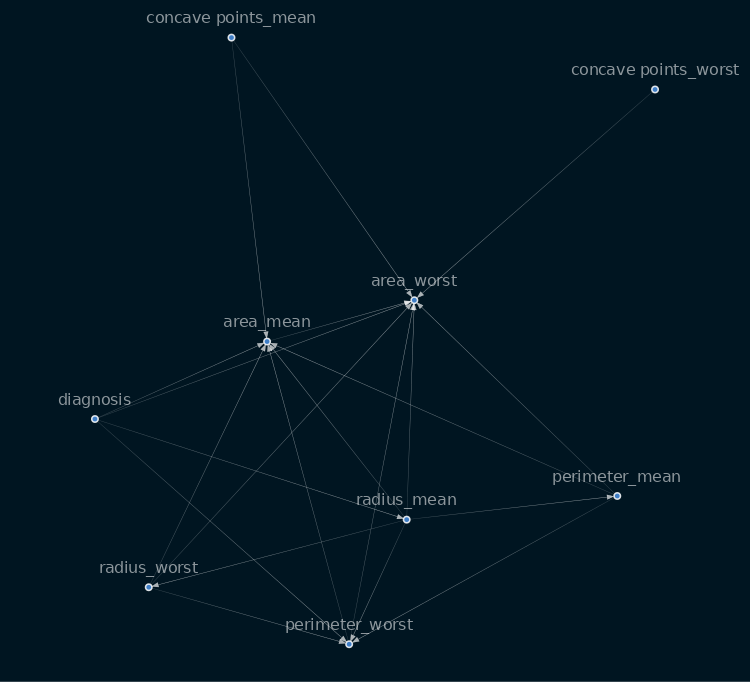

In [15]:
sm_50.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm_50,
    graph_attributes={"scale": "2.5",'size':'2.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

>> #### Modeling

### Discretising the features

In [31]:
discretise_data = causal.discretise(sel_feat)

INFO:logger:Discretising Data
INFO:logger:Discretised Data


In [32]:
discretise_data.head()

,diagnosis,concave points_mean,radius_worst,concave points_worst,perimeter_worst,area_mean,area_worst,perimeter_mean,radius_mean
0,1,0,1,0,1,1,1,1,1
1,1,0,1,0,1,1,1,1,1
2,1,0,1,0,1,1,1,1,1
3,1,0,1,0,1,1,1,1,1
4,1,0,1,0,1,1,1,1,1


Build the Bayesian network

In [18]:
bn = BayesianNetwork(sm_50)

In [19]:
# Create labels for the the diagnosis column
diagnosis_map = {0: "Benign", 1: "Malignant"}
discretise_data["diagnosis"] = discretise_data["diagnosis"].map(diagnosis_map)

discretise_data.head()

,diagnosis,concave points_mean,radius_worst,concave points_worst,perimeter_worst,area_mean,area_worst,perimeter_mean,radius_mean
0,Malignant,0,2,0,2,2,2,2,2
1,Malignant,0,2,0,2,2,2,2,2
2,Malignant,0,2,0,2,2,2,2,2
3,Malignant,0,2,0,2,2,2,2,2
4,Malignant,0,2,0,2,2,2,2,2


>> #### Train/test split

In [33]:
# Split 90% train and 10% test
train, test = train_test_split(discretise_data, train_size=0.9, test_size=0.1, random_state=7)

In [34]:
bn = bn.fit_node_states(discretise_data)

In [35]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [36]:
#inspect the conditional probability distributions of the target variable
bn.cpds["diagnosis"]

,
diagnosis,
0,0.63035
1,0.36965


In [37]:
#make predictions
predictions = bn.predict(discretise_data, "diagnosis")

In [38]:
#classification report
classification_report(bn, test, "diagnosis")

{'diagnosis_0': {'precision': 0.5964912280701754,
  'recall': 1.0,
  'f1-score': 0.7472527472527472,
  'support': 34},
 'diagnosis_1': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 23},
 'accuracy': 0.5964912280701754,
 'macro avg': {'precision': 0.2982456140350877,
  'recall': 0.5,
  'f1-score': 0.3736263736263736,
  'support': 57},
 'weighted avg': {'precision': 0.355801785164666,
  'recall': 0.5964912280701754,
  'f1-score': 0.44572970888760355,
  'support': 57}}

>> ##### Evaluation

In [39]:
roc, auc = roc_auc(bn, test, "diagnosis")
print(auc)

0.5964912280701755
